In [1]:
#Building makemore Part 3: Activations & Gradients, BatchNorm(https://youtu.be/P6sfmUTpUmc?si=Q5mgzxg49be-SR1L)

In [2]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [3]:
words = open('names.txt', 'r').read().split()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = ['.'] + [chr(i + ord('a')) for i in range(26)]
stoi = {s:i for i,s in enumerate(chars)}
itos = {stoi[v]:v for v in stoi}

In [5]:
import random

def crete_training_data(words, context_length):
    xs = []
    ys = []
    for w in words:
        #print(w)
        context = [stoi['.']]*context_length
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            #print(f'{''.join([itos[i] for i in context])} -> {itos[ix]}')
            context = context[1:] + [ix] # rolling window
    return torch.tensor(xs), torch.tensor(ys)

def crete_training_data_with_split(words, context_length, selection_randomization_seed, test_spilit=(0.8,0.1,0.1)):
    random.seed(selection_randomization_seed)
    random.shuffle(words)
    outs = []

    sum_for_test_split = sum(s for s in test_spilit)
    normalized_test_split = [s/sum_for_test_split for s in test_spilit]
    last_start = 0
    for i,s in enumerate(normalized_test_split):
        start = last_start
        if i > 0:
            start += int(normalized_test_split[i - 1] * len(words))
        last_start = start
        end = start + int(s * len(words))
        if i + 1 == len(normalized_test_split):
            end = len(words)
        #print(start,end,len(words))
        xs,ys = crete_training_data(words[start:end],context_length)
        outs.append((xs,ys))
    return outs

In [6]:
data_spilit=(0.8,0.1,0.1)
training_data = crete_training_data_with_split(words, 3, 42, data_spilit)
Xtr,Ytr = training_data[0]
Xdev,Ydev = training_data[1]
Xte,Yte = training_data[2]

print(f'training data size = {Xtr.shape[0]}, input size ={int(len(words) * data_spilit[0])}')
print(f'dev data size = {Xdev.shape[0]}, input size ={int(len(words) * data_spilit[1])}')
print(f'dev data size = {Xte.shape[0]}, input size ={int(len(words) * data_spilit[2])}')

training data size = 182625, input size =25626
dev data size = 22655, input size =3203
dev data size = 22866, input size =3203


In [7]:
#remember if we represent a layer as a matrix we consider every row to be a neuron so we can apply them as x @ matrix so on the columns we have all the waits for a given input

#cleand-up version
def create_concrete_training_data(embading_size):
    words = open('names.txt', 'r').read().split()
    return crete_traininng_data(words, embading_size)

def crate_model_parameters(alphabet_size, num_embading_dimensions, embading_size, number_of_neurons_in_the_hiden_layer, generator_seed):
    #the input space is the same as the output space and the same as the alphabet
    
    #rng for consistency
    g = torch.Generator().manual_seed(generator_seed)
    #embading space
    C = torch.randn((alphabet_size, num_embading_dimensions), generator=g, requires_grad=True)
    #hiden layer
    W1 = torch.randn((num_embading_dimensions * embading_size, number_of_neurons_in_the_hiden_layer), generator=g, requires_grad=True)
    b1 = torch.randn(number_of_neurons_in_the_hiden_layer, generator=g, requires_grad=True)

    #output layer
    W2 = torch.randn((number_of_neurons_in_the_hiden_layer, alphabet_size), generator=g, requires_grad=True)
    b2 = torch.randn(alphabet_size, generator=g, requires_grad=True)
    return [g, C, W1, b1, W2, b2]

def forward(parameters, xs, num_embading_dimensions, embading_size):
    g, C, W1, b1, W2, b2 = parameters
    #embade xs in C
    emb = C[xs]
    
    #apply the hiden layer
    h = torch.tanh(emb.view(-1,num_embading_dimensions * embading_size) @ W1 + b1)
    
    #apply the output layer
    logits = h @ W2 + b2
    
    #soft max
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim=True)
    prob = F.softmax(logits, dim=1)

    return prob

def calculate_loss(parameters, xs, ys, num_embading_dimensions, embading_size):
    g, C, W1, b1, W2, b2 = parameters
    #embade xs in C
    emb = C[xs] #embad the characters in to the vector space C
    embcat = emb.view(-1,num_embading_dimensions * embading_size) # view the embadings in a matrix where all the embading data is in the same row
    #apply the hiden layer
    h = torch.tanh(embcat @ W1 + b1)
    
    #apply the output layer
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, ys)
    return loss

In [8]:
embeding_size = 3
alphabet_size = 27
num_embading_dimensions = 2
number_of_hiden_nerons = 100
generator_seed = 214_748_364_7
learning_ratre = 1

#create model
parameters = crate_model_parameters(alphabet_size, num_embading_dimensions, embeding_size, number_of_hiden_nerons, generator_seed)
num_parameters = sum(p.nelement() for p in parameters[1:])
print(f'num parameters = {num_parameters}')

num parameters = 3481


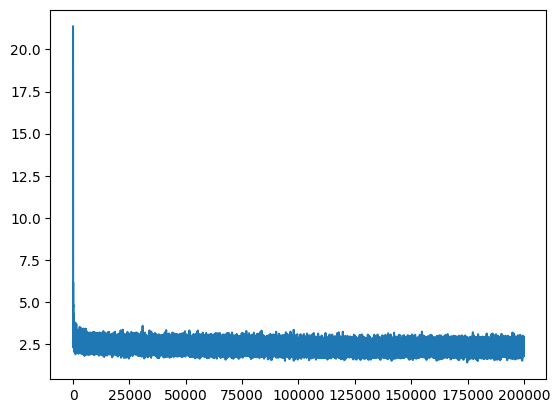

In [9]:
#training
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ##mini batch
    batch_indexes = torch.randint(0, Xtr.shape[0], (batch_size,))
    local_xs = Xtr[batch_indexes]
    local_ys = Ytr[batch_indexes]
    
    ##forward
    loss = calculate_loss(parameters, local_xs, local_ys, num_embading_dimensions, embeding_size)
    lossi.append(loss.item())
    
    ##backward
    for p in parameters[1:]:
        p.grad = None
    loss.backward()

    ##update
    lr = -0.1 if i < 100000 else -0.01
    for p in parameters[1:]:
        p.data += lr * p.grad

plt.plot(lossi)

In [10]:
@torch.no_grad() # disable the calculation of gradients
def split_loss(split):
    x,y = {
        'train' : training_data[0],
        'val'   : training_data[1],
        'test'  : training_data[2],
    }[split]
    loss = calculate_loss(parameters, x, y, num_embading_dimensions, embeding_size)
    print(f'total loss on the {split} data = {loss.item()}')

split_loss('train')
split_loss('val')
split_loss('test')

total loss on the train data = 2.2592062950134277
total loss on the val data = 2.263904571533203
total loss on the test data = 2.2633423805236816


In [11]:
#use
g = torch.Generator().manual_seed(214_748_364_7 + 10)
for _ in range(10):
    ixs = [0] * embeding_size
    output = []
    while True:
        prob = forward(parameters, torch.tensor([ixs]), num_embading_dimensions, embeding_size)
        ix = torch.multinomial(prob, 1, True, generator=g).item()
        if ix == 0:
            break;
        ixs = ixs[1:] + [ix]
        #print(ixs)
        output.append(itos[ix])
    print(''.join(output))

mora
kayah
seel
ndyn
ala
emmastejdrlee
aderedieliighayloen
edelleananar
kayzioh
kalin
